In [336]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
%matplotlib inline



## 1. Problem definition

The main goal of this project is to predict whether a customer will leave the company or not --> 2 desicions --> binary classification

The model is trained with customer data and labels. For that we'll be using supervised learning. 
It’s important to notice that the outcome is uncertain and based on probability.  

> How does the company expect to use and benefit from this model?

Customer churn is a huge issue for businneses and therefore should be an priority. 
Churn prevention allows companies to develop loyalty programs and retention campaigns to keep as many customers as possible. Knowing which customer is about to churn (i.e., stop doing business or end the relationship with the company) is valuable information.

The goal of this Notebook is to predict whether a customer is about to churn. By using machine learning techniques, we can identify patterns and characteristics of customers who are likely to churn, and use this information to proactively address customer concerns and improve retention.

We will compare the following machine learning models: Logistic Regression, K-Nearest Neighbors Classifier, and Random Forest Classifier.

## 2. Data

In [337]:
df = pd.read_csv('Bank_Churn_Data.csv', index_col='RowNumber')
df.shape, df.columns

((10000, 13),
 Index(['CustomerId', 'Surname', 'CreditScore', 'Geography', 'Gender', 'Age',
        'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember',
        'EstimatedSalary', 'Exited'],
       dtype='object'))

In [338]:
df.head()

,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
RowNumber,,,,,,,,,,,,,
1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [339]:
df.nunique()

CustomerId         10000
Surname             2932
CreditScore          460
Geography              3
Gender                 2
Age                   70
Tenure                11
Balance             6382
NumOfProducts          4
HasCrCard              2
IsActiveMember         2
EstimatedSalary     9999
Exited                 2
dtype: int64

### Data Set:

- We are working with structured and static data. 
- It consists of 10000 observations and 12 variables.
- The deependent variable refers to the customer abandonment.

### Features:

- CustomerId
- Surname
- CreditScore
- Geography: Country (Germany / France / Spain)
- Gender: Female / Male
- Age
- Tenure: How many years of customer ([0, 11])
- Balance
- NumOfProducts: Bank product used ([0, 4])
- HasCrCard: Credit card status (0 = No, 1 = Yes)
- IsActiveMember: Active membership status (0 = No, 1 = Yes)
- EstimatedSalary
- Exited: Abandoned or not? (0 = No, 1 = Yes)

source: https://www.kaggle.com/datasets/mathchi/churn-for-bank-customers/data

## 3. Evaluation

Metrics for the classification problem: accuray and precion/recall (confusion matrix) important.

The main purpose of this task is to identify as many churned customers as possible. The more, the better. Therefore, recall is the most important. 
Recall refers to the number of churned customers identified by the model divided by the total number of customers who have actually churned, as expressed in formula: Recall = True Positive / (True Positive + False Negative).

## 4. Understanding Features / Exploratory data analysis (EDA)

Next we will have a look on the dataset and get familiar with it. 

RowNumber and CustomerID could be removed as both are specific to a customer and fail to provide value-added information in identifying potential customers who churned. Surname is likely to cause profiling, thus preferably to be excluded. Exited column is target variable.

In [340]:
df = df.drop(["CustomerId","Surname"], axis=1)

In [341]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10000 entries, 1 to 10000
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CreditScore      10000 non-null  int64  
 1   Geography        10000 non-null  object 
 2   Gender           10000 non-null  object 
 3   Age              10000 non-null  int64  
 4   Tenure           10000 non-null  int64  
 5   Balance          10000 non-null  float64
 6   NumOfProducts    10000 non-null  int64  
 7   HasCrCard        10000 non-null  int64  
 8   IsActiveMember   10000 non-null  int64  
 9   EstimatedSalary  10000 non-null  float64
 10  Exited           10000 non-null  int64  
dtypes: float64(2), int64(7), object(2)
memory usage: 937.5+ KB


 There are no missing values. So we dont have to hande missing values in this case. Next, we check proportion of customer churned and retained.

In [342]:
target_count = df["Exited"].value_counts(normalize=True)
target_count

Exited
0    0.7963
1    0.2037
Name: proportion, dtype: float64

We can see that around 20% of customers in the dataset churned, which sets a baseline for the models to identify at least 20% of customers as churners. To improve this, we can try to handle the class imbalance issue using SMOTE (Synthetic Minority Over-sampling Technique). Since the churned customers make up only a minority of the dataset, SMOTE will generate synthetic examples of the minority class (churners) to balance the dataset, which can help the model to better learn the patterns associated with customer churn.

Next try to understand the features by statistcs and some graphics.

In [343]:
df.describe()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,650.528800,38.921800,5.012800,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700
std,96.653299,10.487806,2.892174,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769
min,350.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,584.000000,32.000000,3.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,652.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,718.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000
max,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000


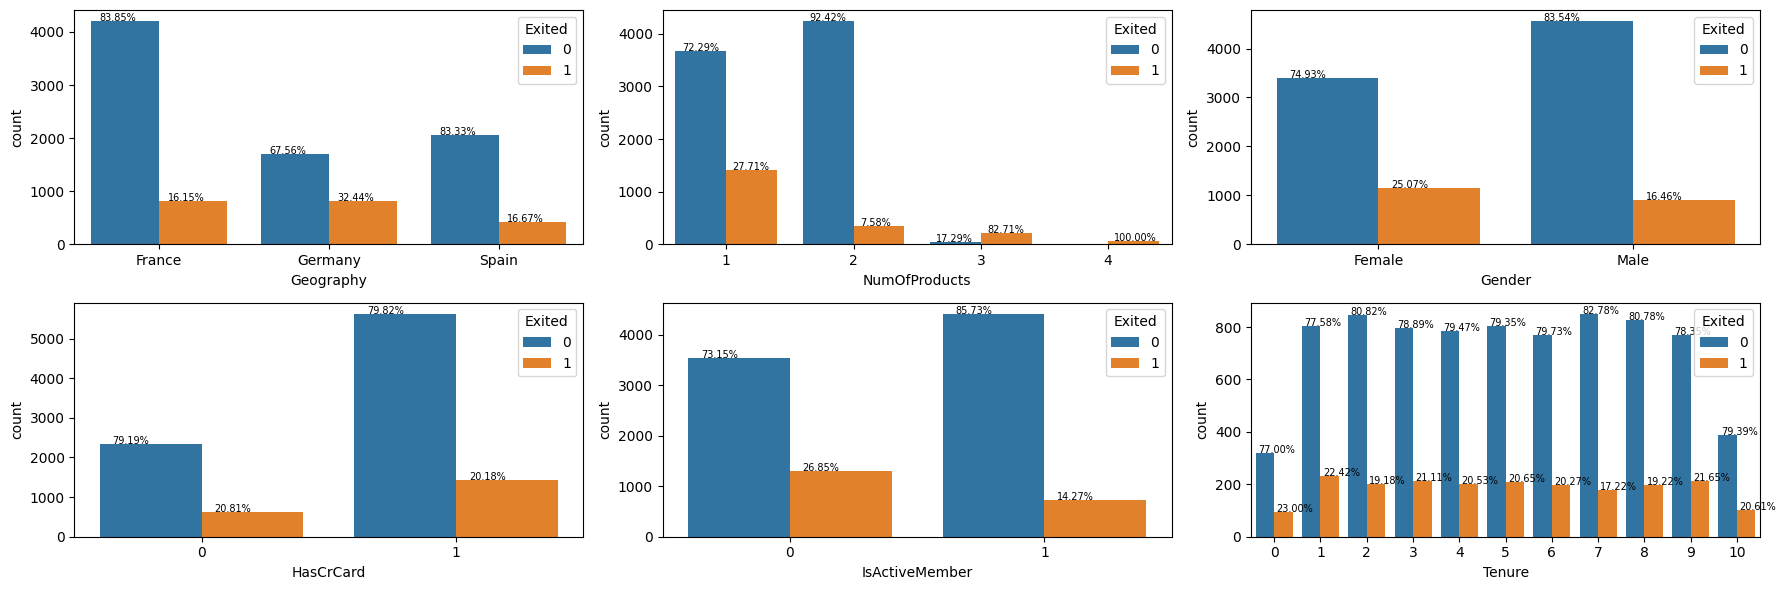

In [344]:
# source https://github.com/houyonglu58/Bank_Customer_Churn_Prediction

def with_hue(plot, feature, df):
    patch = [p for p in plot.patches]
    
    feature_categories = sorted(df[feature].unique())
    exited_categories = sorted(df['Exited'].unique())
    #print(feature_categories)
    abc = 0
    for i in exited_categories:
        for j, cats in enumerate(feature_categories):

            total = df[df[feature] == cats]["Exited"].count()

            if total > 0:
                filtered_count = df[(df[feature] == cats) & (df['Exited'] == i)].shape[0]

                pct = "{:.2f}%".format(round(100 * (filtered_count / total), 2))

                if filtered_count != 0:
                    patch_index = j + i * len(feature_categories)  # Make sure it's an integer index
                    x = patch[patch_index-abc].get_x() + patch[patch_index-abc].get_width() / 2 - 0.15
                    y = patch[patch_index-abc].get_y() + patch[patch_index-abc].get_height()
                    plot.annotate(pct, (x, y), size=7)
                else:
                    abc += 1
                    
def show_categorical_features(df):
    fig, axarr = plt.subplots(2, 3, figsize=(18, 6))
    categorical_val = ["Geography", "NumOfProducts", "Gender", "HasCrCard", "IsActiveMember", "Tenure"]

    for i, n in enumerate(categorical_val):
        ax_ = axarr[i // 3][i % 3]
        sns.countplot(x = n, hue="Exited", data=df, ax=ax_, order=sorted(df[n].unique()))
        with_hue(ax_, str(n), df)

    plt.tight_layout()
    plt.show()

show_categorical_features(df)


- Geography:
The majority of customers are from France, with Spain and Germany having a relatively equal number of customers. Interestingly, Germany has the highest churn rate (over 30%) with the lowest customer numbers, while France has the least churn rate (less than 20%) with the largest customer community. 

- Number of Product:
Customers that are owning 3 or more products are more likely to churn than customers who own 2 or less. The majority of the customers own 1 or 2 products while a minority of customers owns 3 or more. 

- Gender: Male customers are more likely to churn than female customers. 

- HasCrCard: The majority of customers have credit cards. Churn rates between customers with credit cards and those without are almost the same (20%).

- IsActiveMember: Customers who are non-active members are more likely to churn (26%) than those who are active (14%).

- Tenure: You cannot really see a difference in exit rates but when at 0 and 10 years there's the biggest difference.

In [345]:
def show_numeric_features(df):
    fig, axarr = plt.subplots(2, 2, figsize=(20, 20))
    sns.histplot(x = 'Age', hue = 'Exited',data = df, ax = axarr[0][0], kde=True)
    sns.histplot(x = 'Balance', hue = 'Exited',data = df, ax = axarr[0][1], kde=True)
    sns.histplot(x = 'EstimatedSalary', hue = 'Exited', data = df, ax = axarr[1][0], fill = True, kde=True)
        # sns.kdeplot(data = df,
        #         x = column,
        #         fill = True,
        #         alpha = 0.5,
        #         hue = 'Exited',
        #         palette = [ '#7FFFD4', '#008080'],
        #         ax = ax)
    sns.histplot(x = 'CreditScore', hue = 'Exited',data = df, ax = axarr[1][1], kde=True)

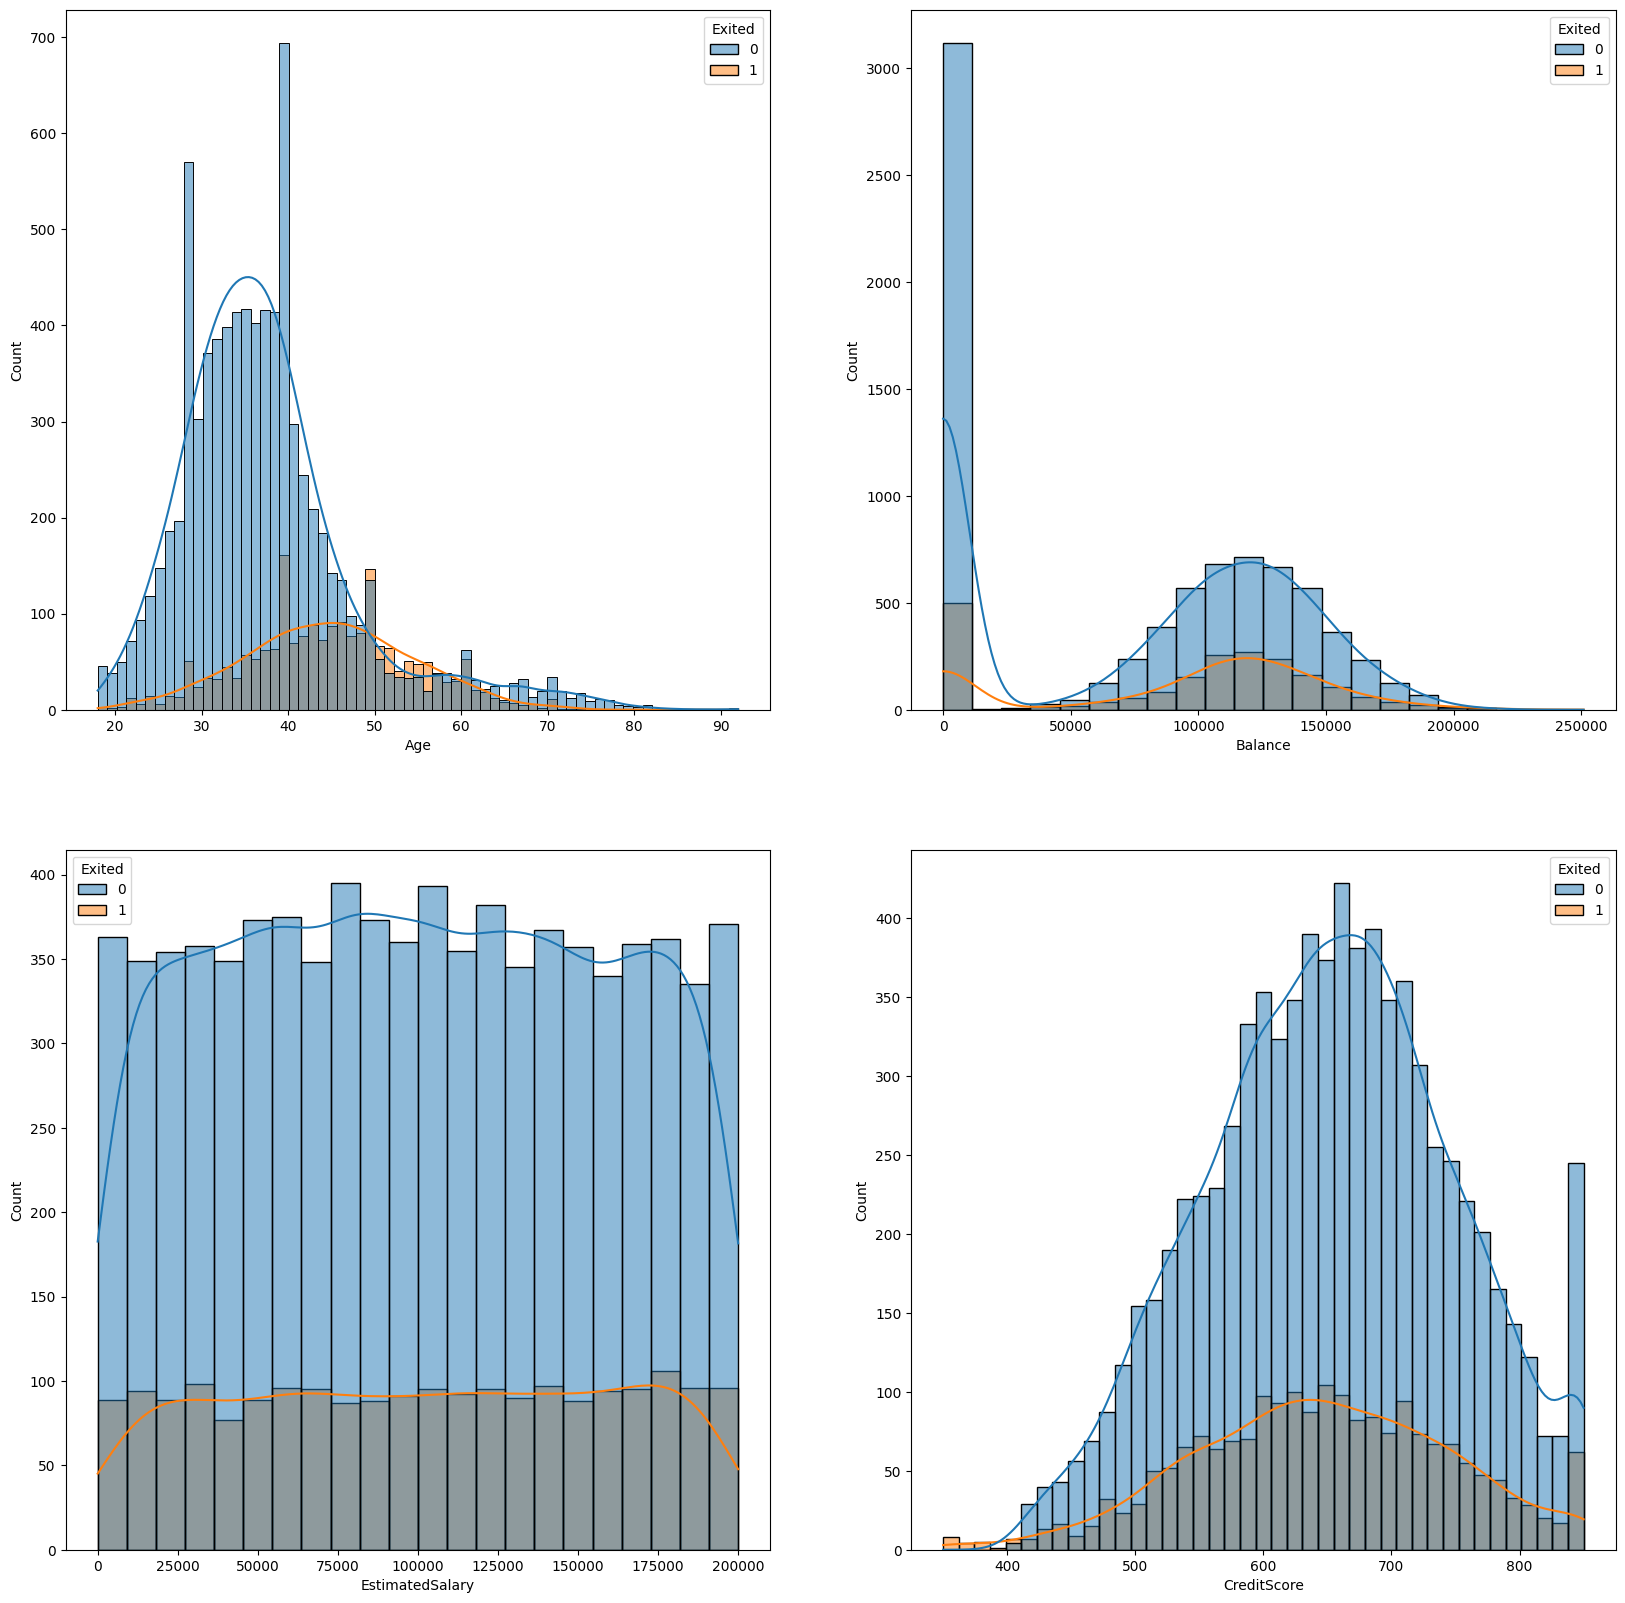

In [346]:
show_numeric_features(df)

- Age: Among customers who churned, half of them are middle-aged (40+) or considered gerontic (70). Oppositely, customers who retained are generally quite young, with 75% aged under 40. Chances are that the bank is having a service preference towards differnet age categories. We could advice the bank to review its market strategy and customer services between different age groups for further validation.

- Balance: Many customers have a balance close to zero, but many people have balances around 10000. Customers who churn tend to have higher balances. 

- Credit Score: Most customers have a credit scores between 500 and 800. Customers who churn are slightly more concentrated around the lower credit scores.

- Estimated Salary: Estimated Salary is uniformly distributed for both exited and non-exited customers. 


In [347]:
df["Gender"] = df["Gender"].map({'Female': 0, 'Male': 1})

# source https://www.kaggle.com/code/obayprogrammer/customer-churn-predictor

df = pd.get_dummies(df, columns=["Geography"])
df.head()

,CreditScore,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_France,Geography_Germany,Geography_Spain
RowNumber,,,,,,,,,,,,,
1,619,0,42,2,0.00,1,1,1,101348.88,1,True,False,False
2,608,0,41,1,83807.86,1,0,1,112542.58,0,False,False,True
3,502,0,42,8,159660.80,3,1,0,113931.57,1,True,False,False
4,699,0,39,1,0.00,2,0,0,93826.63,0,True,False,False
5,850,0,43,2,125510.82,1,1,1,79084.10,0,False,False,True


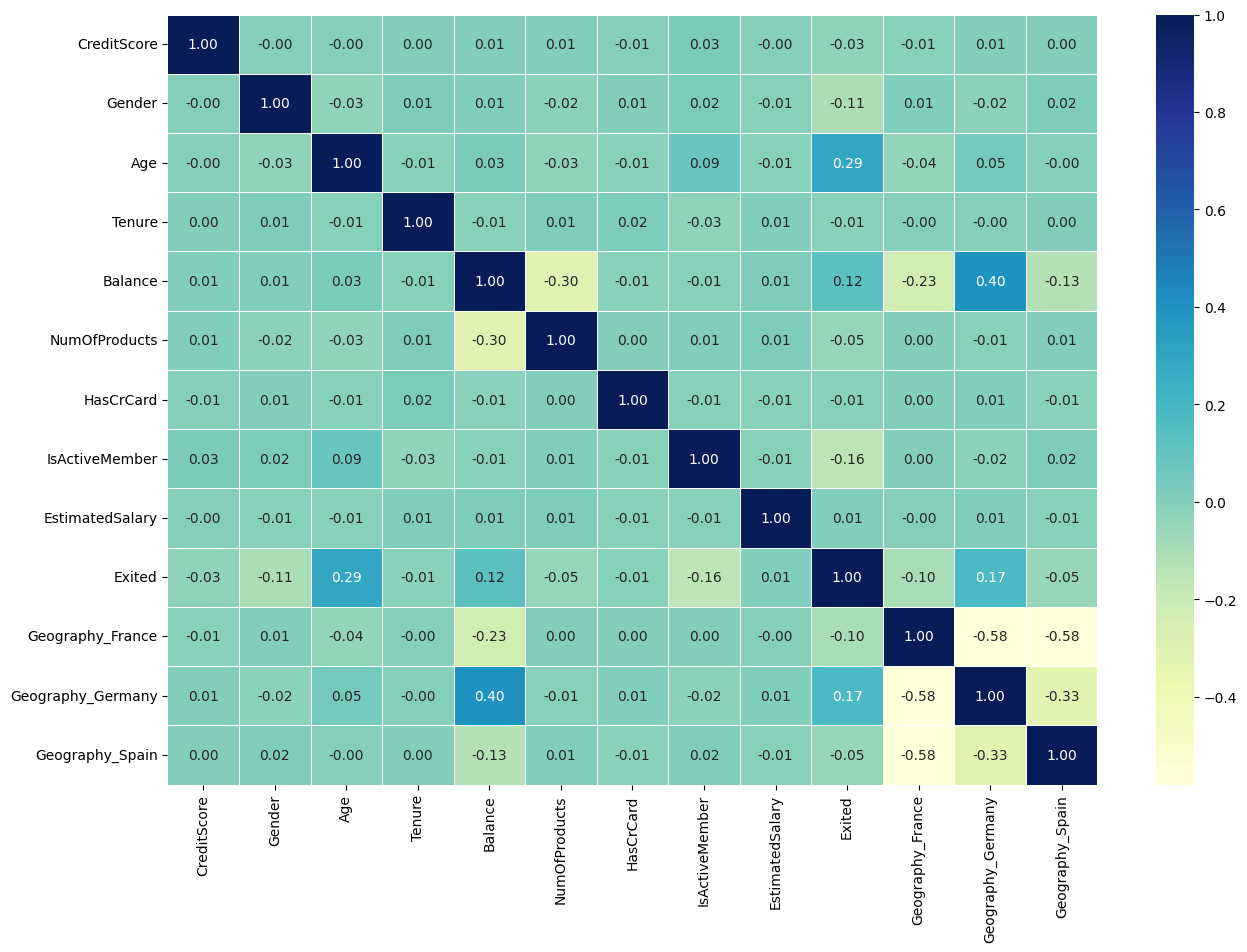

In [348]:
corr_matrix = df.corr()
plt.figure(figsize=(15, 10))
sns.heatmap(corr_matrix, annot=True, linewidths=0.5, fmt=".2f", cmap="YlGnBu");

> Q: Study the correlation between the features in your data set

- Age (0.29): Older customers are more likely to churn.

- Balance (0.12): Customers with a higher balance tend to churn slightly more.

- IsActiveMember (-0.16): Active members are less likely to leave.

- Geography: German customers have the strongest positive correlation with churn, meaning they are the most likely to leave. France and Spain have a negative correlation with churn. 

- Geography German (0.40): High correlation with Balance

- Num of Products (-0.30): negative correlation with balance


## 5. Models

Now we understand our data, know the features and extract our features. Now we can create and test some ML Models. But first we need to split our dataset. 

> Q: Why not use all the data to train a model?

The first step is splitting the data so that the test dataset won't influence the model and the metrics.
Splitting the dataset is necessary to test a model. 
It only make sense to test with data that is unknown to the model.



In [349]:
X = df.drop("Exited",axis=1)
y = df["Exited"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

len(X), len(X_train), len(X_test)

(10000, 8000, 2000)

In [359]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler
#scaler = MinMaxScaler()
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [360]:
np.random.seed(42)

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report

models = { "Logistic Regression": LogisticRegression(max_iter=500, solver='liblinear'),
           "KNN": KNeighborsClassifier(),
           "Random Forest": RandomForestClassifier()}


def fit_and_score(models, X_train, X_test, y_train, y_test):

    score = {}
    confusion_matrices = {}
    classification_reports = {}
    for name, model in models.items():
        model.fit(X_train, y_train);
        score [name] = model.score(X_test, y_test)
        y_pred = model.predict(X_test)
        confusion_matrices[name] = confusion_matrix(y_test, y_pred)
        confusion_matrices[name] = pd.DataFrame(confusion_matrix(y_test, y_pred),columns=["Predicted 0","Predicted 1"],index=["Actual 0","Actual 1"])
        classification_reports[name] = classification_report(y_test, y_pred)

    return score, confusion_matrices, classification_reports


model_scores, confusion_matrices, classification_reports = fit_and_score(models=models,
                                                                         X_train=X_train,
                                                                         X_test=X_test,
                                                                         y_train=y_train,
                                                                         y_test=y_test)


print("Model Scores:", model_scores)
print("\nConfusion Matrices:")
for model_name, matrix in confusion_matrices.items():
    print(f"\n{model_name} Confusion Matrix:\n{matrix}")

print("\nClassification Reports:")
for model_name, report in classification_reports.items():
    print(f"\n{model_name} Classification Report:\n{report}")

Model Scores: {'Logistic Regression': 0.811, 'KNN': 0.83, 'Random Forest': 0.8665}

Confusion Matrices:

Logistic Regression Confusion Matrix:
          Predicted 0  Predicted 1
Actual 0         1543           64
Actual 1          314           79

KNN Confusion Matrix:
          Predicted 0  Predicted 1
Actual 0         1514           93
Actual 1          247          146

Random Forest Confusion Matrix:
          Predicted 0  Predicted 1
Actual 0         1548           59
Actual 1          208          185

Classification Reports:

Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.96      0.89      1607
           1       0.55      0.20      0.29       393

    accuracy                           0.81      2000
   macro avg       0.69      0.58      0.59      2000
weighted avg       0.78      0.81      0.77      2000


KNN Classification Report:
              precision    recall  f1-score   support

       

> Q: Explain what you see on a confusion matrix, and what are precision, recall and F1 score.

- Confusion Matrix: We are able to see the True Positves (TP), True Negatives (TN), False Positves (FP) and False Negatives (FN) predictions.
- Precicion: accuracy of positive predictions TP / TP + FP
- Recall: ratio of predicted positive to all actual positives TP / TP + FN
- F1 Score: The F1 score is the harmonic mean of precision and recall. 2 * ((Precision * Recall) / (Precision + Recall)) 

```python
Logistic Regression Confusion Matrix:
          Predicted 0  Predicted 1
Actual 0         1543           64
Actual 1          314           79

1543 are predicted true as not exited
64 are predictet as exited but they are not exited
314 are preditcts as not exited but they were exited
only 79 are predicted as true exited
```

### Evaluation

Model Scores: {'Logistic Regression': 0.811, 'KNN': 0.83, 'Random Forest': 0.8665}

Every Model got good scores. But when we have a look on exited predictions, we see that they perfom really bad against the not exited. We remember to dedect all Exited Customer. So we need the Recall of the exited customers and its less than 50 % on every model.

Lets try to boost the Recall.

## Experiments

Lets see what SMOTE do. We want to upsample the exited examples.

In [354]:
pd.Series(y_train).value_counts()

Exited
0    6356
1    1644
Name: count, dtype: int64

In [355]:
# source https://www.kaggle.com/code/quartzcore/bank-churn-prediction-with-logreg-and-smote

from imblearn.over_sampling import SMOTE
sm = SMOTE(sampling_strategy='minority', random_state=42)
X_train_upsampled, y_train_upsampled = sm.fit_resample(X_train, y_train)
output = sm.fit_resample(X_train, y_train)

pd.Series(y_train_upsampled).value_counts()


Exited
0    6356
1    6356
Name: count, dtype: int64

In [356]:
np.random.seed(42)

models = { "Logistic Regression": LogisticRegression(max_iter=500, solver='liblinear'),
           "KNN": KNeighborsClassifier(),
           "Random Forest": RandomForestClassifier()}


def fit_and_score(models, X_train, X_test, y_train, y_test):

    score = {}
    confusion_matrices = {}
    classification_reports = {}
    for name, model in models.items():
        model.fit(X_train, y_train);
        score [name] = model.score(X_test, y_test)
        y_pred = model.predict(X_test)
        confusion_matrices[name] = pd.DataFrame(confusion_matrix(y_test, y_pred),columns=["Predicted 0","Predicted 1"],index=["Actual 0","Actual 1"])
        classification_reports[name] = classification_report(y_test, y_pred)

    return score, confusion_matrices, classification_reports


model_scores, confusion_matrices, classification_reports = fit_and_score(models=models,
                                                                         X_train=X_train_upsampled,
                                                                         X_test=X_test,
                                                                         y_train=y_train_upsampled,
                                                                         y_test=y_test)


print("Model Scores:", model_scores)
print("\nConfusion Matrices:")
for model_name, matrix in confusion_matrices.items():
    print(f"\n{model_name} Confusion Matrix:\n{matrix}")

print("\nClassification Reports:")
for model_name, report in classification_reports.items():
    print(f"\n{model_name} Classification Report:\n{report}")

Model Scores: {'Logistic Regression': 0.721, 'KNN': 0.742, 'Random Forest': 0.8405}

Confusion Matrices:

Logistic Regression Confusion Matrix:
          Predicted 0  Predicted 1
Actual 0         1163          444
Actual 1          114          279

KNN Confusion Matrix:
          Predicted 0  Predicted 1
Actual 0         1231          376
Actual 1          140          253

Random Forest Confusion Matrix:
          Predicted 0  Predicted 1
Actual 0         1447          160
Actual 1          159          234

Classification Reports:

Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.72      0.81      1607
           1       0.39      0.71      0.50       393

    accuracy                           0.72      2000
   macro avg       0.65      0.72      0.65      2000
weighted avg       0.81      0.72      0.75      2000


KNN Classification Report:
              precision    recall  f1-score   support

      

We can see that we get much better Recall. In the Confusion Matrix we can see that we dedect more exitet customers, but we also dedect more wrong exited customers -- we lose precision and f1-score. 

In [363]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import RandomizedSearchCV
import numpy as np


rf_grid = {
    "randomforestclassifier__n_estimators": np.arange(50, 301, 50),  
    "randomforestclassifier__max_depth": [None, 10, 20, 30, 40, 50],
    "randomforestclassifier__min_samples_split": [2, 5, 10],  
    "randomforestclassifier__min_samples_leaf": [1, 2, 4],  
    "randomforestclassifier__bootstrap": [True, False]  
}

pipeline = make_pipeline(StandardScaler(), RandomForestClassifier(random_state=42))


rs_rf = RandomizedSearchCV(pipeline,
                           param_distributions=rf_grid,
                           cv=5,
                           n_iter=20,  
                           verbose=True,
                           n_jobs=-1,  
                           random_state=42)

rs_rf.fit(X_train_upsampled, y_train_upsampled)

print("Beste Hyperparameter:", rs_rf.best_params_)




Fitting 5 folds for each of 20 candidates, totalling 100 fits
Beste Hyperparameter: {'randomforestclassifier__n_estimators': np.int64(250), 'randomforestclassifier__min_samples_split': 2, 'randomforestclassifier__min_samples_leaf': 1, 'randomforestclassifier__max_depth': 50, 'randomforestclassifier__bootstrap': False}


In [ ]:
test_score = rs_rf.score(X_test, y_test)
print("Testgenauigkeit:", test_score)
y_pred = rs_rf.predict(X_test)
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Testgenauigkeit: 0.8435

Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.91      0.90      1607
           1       0.61      0.56      0.59       393

    accuracy                           0.84      2000
   macro avg       0.75      0.74      0.74      2000
weighted avg       0.84      0.84      0.84      2000



## Conclusion

### Work Done
- EDA
- Precion/Recall Confusion Matrix
- SMOTE
- Comparing Models
- Hyperparameters

### Further Work
- More feature engineering
- More Hyperparameter tuning 